# 시나리오
- 무작위의 생선이 하나 들어있는 랜덤생선박스를 판매하려고 함
- 완전 무작위 판매가 아닌 선호하는 생선 확률을 보여주고 선택이 가능하도록
    ex) A박스에 도미가 있을 확률을 표시
- 박스에 들어있는 생선의 확률을 구해야 함

## 랜덤생선박스의 확률
- 생선의 종류 7가지
- 생선의 특성이 주어지면 7개 생선에 대한 확률을 구함
- 길이, 높이, 두께, 대각선길이를 특성으로 사용
- 이진분류(타겟이 두 종류)와 다중분류(타겟이 세 종류 이상)

## k-최근접 이웃 분류기 사용해보기
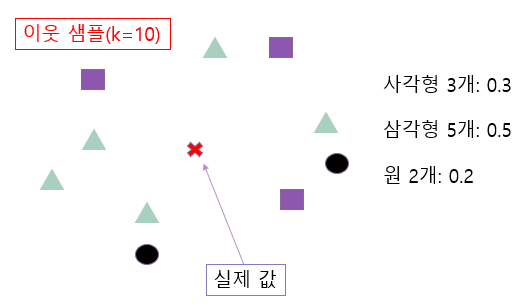
- 그림과 같은 개념으로 랜덤생선박스의 확률을 표현할 수 있음

#### 데이터 준비

In [2]:
import pandas as pd

fish = pd.read_csv('fish_csv_data.csv')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


#### 생선 종류 확인

In [3]:
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


#### 분류에 사용할 훈련 데이터 열과 타겟데이터 열 선택

In [4]:
fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()
fish_input[:5]

array([[242.    ,  25.4   ,  30.    ,  11.52  ,   4.02  ],
       [290.    ,  26.3   ,  31.2   ,  12.48  ,   4.3056],
       [340.    ,  26.5   ,  31.1   ,  12.3778,   4.6961],
       [363.    ,  29.    ,  33.5   ,  12.73  ,   4.4555],
       [430.    ,  29.    ,  34.    ,  12.444 ,   5.134 ]])

In [5]:
fish_target = fish['Species'].to_numpy()
fish_target[:5]

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

#### 훈련 데이터와 테스트 데이터 나누기

In [6]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

#### 훈련 데이터셋과 테스트 데이터셋 표준화
- StandardScaler 사용

In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [8]:
train_scaled[:5]

array([[ 0.91965782,  0.60943175,  0.81041221,  1.85194896,  1.00075672],
       [ 0.30041219,  1.54653445,  1.45316551, -0.46981663,  0.27291745],
       [-1.0858536 , -1.68646987, -1.70848587, -1.70159849, -2.0044758 ],
       [-0.79734143, -0.60880176, -0.67486907, -0.82480589, -0.27631471],
       [-0.71289885, -0.73062511, -0.70092664, -0.0802298 , -0.7033869 ]])

#### k-최근접 이웃 모델 사용

In [9]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3) # 이웃 개수 3개로
kn.fit(train_scaled, train_target)

print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


#### 타겟 클래스 확인
- 분류된 클래스 확인

In [10]:
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


'Bream': 도미
'Parkki' : 파키
'Perch' : 농어
'Pike' : 강꼬치고기
'Roach' : 로치
'Smelt' : 바다빙어
'Whitefish' : 백어

#### 분류 예측

In [11]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


#### 분류기의 예측 확률 확인

In [12]:
import numpy as np

proba = kn.predict_proba(test_scaled[:5])
print(kn.classes_)
print(np.round(proba, decimals=4))

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


In [22]:
distances, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


##### 결과
- kneighbors()메서드는 2차원 배열을 전달해야 함(슬라이싱 하면 2차원 반환)
- 테스트 데이터셋의 4번째 샘플을 예측
- Roach가 하나(30%) Perch가 둘(60%)로 Perch라고 분류함
- 확률은 이웃의 개수로 만들어짐
- 예제는 3개의 이웃을 사용하므로 네 가지 확률이 나옴
    - 0/3, 1/3, 2/3, 3/3
- 확률이라고 하기에는 다소 아쉬움

# 로지스틱 회귀(Logistic Regression)
- 이름은 회귀이나 분류 모델임
- 선형 회귀와 동일한 선형 방정식으로 학습
    - $z = a \times (weight) + b \times (length) + c \times (diagonal) + d \times (height) + e \times (width) + f$
- a, b, c, d는 가중치 또는 계수(다중 회귀를 위한 선형 방정식과 동일)
- z는 어떤 값이라도 상관 없지만 확률이 되려면 0 ~ 1 (0 ~ 100%)
- 시그모이드 함수를 활용
    - z가 아주 큰 음수면 0, 아주 큰 양수면 1을 사용하도록 만드는 것
    - $\varnothing = {1 \over 1+{e^{-z}}}$
    - 자연상수 $e$를 선형 방정식의 출력 $z$의 음수로 거듭제곱하고 1을 더한 값의 역수를 취함
    - 다음과 같은 그래프를 만들 수 있음
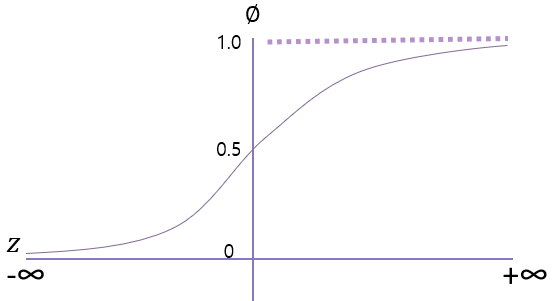
    

In [18]:
import numpy as np
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.1) # -5 ~ 5 까지 값을 0.1단위로 생성
z

array([-5.00000000e+00, -4.90000000e+00, -4.80000000e+00, -4.70000000e+00,
       -4.60000000e+00, -4.50000000e+00, -4.40000000e+00, -4.30000000e+00,
       -4.20000000e+00, -4.10000000e+00, -4.00000000e+00, -3.90000000e+00,
       -3.80000000e+00, -3.70000000e+00, -3.60000000e+00, -3.50000000e+00,
       -3.40000000e+00, -3.30000000e+00, -3.20000000e+00, -3.10000000e+00,
       -3.00000000e+00, -2.90000000e+00, -2.80000000e+00, -2.70000000e+00,
       -2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00,
       -2.20000000e+00, -2.10000000e+00, -2.00000000e+00, -1.90000000e+00,
       -1.80000000e+00, -1.70000000e+00, -1.60000000e+00, -1.50000000e+00,
       -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00,
       -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -1.77635684e-14,  1.00000000e-01,
        2.00000000e-01,  

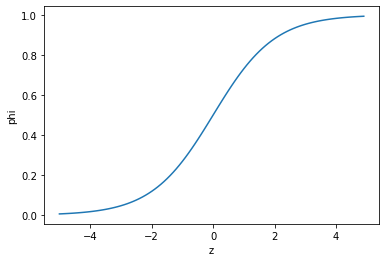

In [19]:
phi = 1 / (1 + np.exp(-z))

plt.plot(z, phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

##### 결과
- -5 ~ 5까지의 0.1단위의 값을 0 ~ 1 사이로 표현함(가둔다고 표현)

## 로지스틱 회귀로 이진 분류 하기

In [20]:
import numpy as np

char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
print(char_arr[[True, False, True, False, False]])

['A' 'C']


#### 훈련 세트에서 도미(Bream)와 빙어(Smelt)의 행들만 가져오기

In [16]:
train_target == 'Bream' # 도미인 데이터 확인

array([ True, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
       False,  True, False,  True, False, False, False,  True, False,
       False,  True, False, False, False, False,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False])

In [17]:
train_target == 'Smelt' # 빙어인 데이터 확인

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False])

In [18]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt') # 두 가지만 고름
bream_smelt_indexes

array([ True, False,  True, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True,  True, False,
       False,  True, False,  True, False, False, False,  True, False,
       False,  True, False, False, False, False,  True, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False,  True, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False])

In [19]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt') # 두 가지만 고름
train_bream_smelt = train_scaled[bream_smelt_indexes] # 도미와 빙어만 훈련 데이터로 생성
target_bream_smelt = train_target[bream_smelt_indexes] # 도미와 빙어만 테스트 데이터로 생성

### LogisticRegression 모델로 이진 분류 하기

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

LogisticRegression()

In [21]:
# 예측하기
print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


In [22]:
# 퍼센트 확인
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


In [23]:
# 분류 클래스 확인
print(lr.classes_)

['Bream' 'Smelt']


In [24]:
# 회귀 계수 확인
print(lr.coef_, lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


##### 방정식
$z = -0.404 \times (weight) + -0.576 \times (length) + -0.662 \times (diagonal) + -1.012 \times (height) + -0.731 \times (width) + -2.161$

In [25]:
# z값 확인
decision = lr.decision_function(train_bream_smelt[:5])
print(decision)

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


In [47]:
# 시그모이드 함수에 적용하면 확률을 구할 수 있음
from scipy.special import expit # 시그모이드 함수

print(expit(decision))

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


##### 결과
- decision_function() 메서드는 양성인 클래스에 대한 z값 확인 가능

### LogisticRegression 모델로 다중 분류 하기
- 기본적으로 반복적인 알고리즘을 사용
- max_iter옵션으로 반복 횟수 지정(기본값: 100)
- 릿지 회귀와 같이 계수의 제곱을 규제(L2규제)
- 규제 제어 매개변수 C(기본값: 1)이며 alpha와 반대 개념으로 적용(값이 작으면 규제가 커짐)

In [28]:
# 훈련하기
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


##### 결과
- 훈련 데이터셋과 테스트 데이터셋에 대한 점수가 높음
- 과대적합이나 과소적합은 아닌 것으로 보임

In [59]:
# 예측
lr.predict(test_scaled[:5])

array(['Perch', 'Smelt', 'Pike', 'Roach', 'Perch'], dtype=object)

In [30]:
# 퍼센트 확인
proba = lr.predict_proba(test_scaled[:5])
print(lr.classes_)
print(np.round(proba, decimals=3))

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


##### 해석
- 첫 번째 열이 음성 클래스(0)에 대한 확률
- 두 번째 열은 양성 클래스(1)에 대한 확률
- 분류된 클래스들은 타겟값을 알파벳 순으로 정렬하여 사용(classes_ 속성으로 확인)

In [61]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [62]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


##### 해석
- 5개의 특성을 사용했으므로 열이 5개 이다.
- 분류를 위한 행은 7개 이다.
- 각각의 클래스마다의 확률을 모두 계산
- 이중 분류는 시그모이드를 적용하고, 다중 분류는 소프트맥스 함수를 사용함

#### 소프트맥스(softmax) 함수
- 시그모이드 함수는 하나의 선형 방정식의 출력 값을 0~1로 압축
- 소프트맥스 함수는 여러 개의 선형 방정식의 출력값을 0~1로 압축하고 전체 합이 1이 되도록 만듦
- 지수함수를 사용하므로 정규화된 지수함수라고도 불림

- 
- $z1$ \~ $z7$ 까지 값을 사용하여 지수함수($e^{z1}$ \~ $e^{z7}$)을 계산하여 합을 구함(e_sum)
    - $ e\_sum = e^{z1} + e^{z2} + e^{z3} + e^{z4} + e^{z5} + e^{z6} + e^{z7}$
- $e^{z1}$ \~ $e^{z7}$을 각각 $e\_sum$으로 나눔
    - $ s1 = { e^{z1} \over e\_sum}, s2 = { e^{z2} \over e\_sum}, ... s7 = { e^{z7} \over e\_sum}$ 
- 이렇게 나온 $e^{s1}$ \~ $e^{s7}$을 모두 더하면 1이 된다.(7개 생선에 대한 확률의 합은 1이어야 함)

In [31]:
# 훈련 데이터의 첫 번째 샘플에 대한 확률 값을 이용하여 1이 되는지 확인
0 + 0.014 + 0.841 + 0 + 0.136 + 0.007 + 0.003

1.001

#### decision_function()메서드로 직접 해보기

In [66]:
# 테스트 데이터셋의 처음 5개 샘플에 대한 z1~z7 값 구하기
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


In [74]:
# softmax함수로 확률 확인
from scipy.special import softmax

proba = softmax(decision, axis=1) #  axis=1 행 단위로 계산하도록 축을 설정
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [75]:
# predict_proba와 비교
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


##### 결과
- 로지스틱 회귀 모델이 구한 확률과 동일한
- 로지스틱 회귀로 이중, 다중 분류를 수행할 수 있음

## 정리하기

### 로지스틱 회귀
- 선형 방정식을 사용한 분류 알고리즘
- 선형 회귀와 달리 시그모이드 함수 또는 소프트맥스 함수를 사용하여 클래스 확률 출력 가능

### 다중 분류
- 분류할 타겟 클래스가 3개 이상인 분류 문제
- 로지스틱 회귀는 다중 분류를 위해 softmax함수를 사용

### 시그모이드 함수
- 선형 방정식의 출력을 0과 1사이의 값으로 압축
- 이진 분류를 위해 사용

### 소프트맥스 함수
- 다중 분류 시 여러 타겟 클래스에 대한 선형 방정식의 출력 결과를 정규화
- 정규화된 값의 총 합이 1이 되도록 하여 확률을 구함